## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [4]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchtext

import spacy

import random
import math
import time
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from torchtext.vocab import vocab as Vocab
from torch.nn.utils.rnn import pad_sequence
from tokenizers import Tokenizer, pre_tokenizers, normalizers, decoders
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import Lowercase, StripAccents
import torchnlp.nn

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

torch.manual_seed(42)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
with open("data.txt") as f:
    data = [s.rstrip().split("\t") for s in f]


tokenizer = WordPunctTokenizer()
def tokenize(sentance):
    return tokenizer.tokenize(sentance.lower())


tokenized_data = [[tokenize(x[0]), tokenize(x[1])] for x in data]

print(tokenized_data[0])

[['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.'], ['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']]


Let's check the length distributions:

Length distribution in dataset


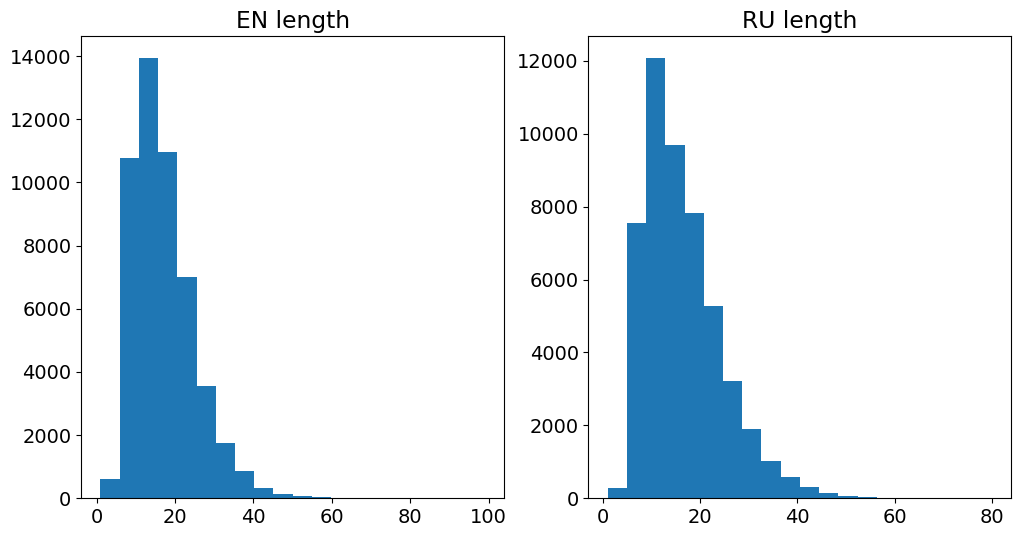

In [4]:
src_length = map(len, [x[0] for x in tokenized_data])
trg_length = map(len, [x[1] for x in tokenized_data])

print('Length distribution in dataset')
plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.title("EN length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("RU length")
plt.hist(list(trg_length), bins=20);

In [5]:
def build_vocabs(tokenized_data, min_freq):
    src_counter = Counter([x for xs in tokenized_data for x in xs[0]])
    trg_counter = Counter([x for xs in tokenized_data for x in xs[1]])

    SRC_vocab = Vocab(src_counter, min_freq)
    TRG_vocab = Vocab(trg_counter, min_freq)

    for vocab in [SRC_vocab, TRG_vocab]:
        vocab.insert_token('<pad>', index=0)
        vocab.insert_token('<unk>', index=1)
        vocab.set_default_index(1)
        vocab.insert_token('<sos>', index=2)
        vocab.insert_token('<eos>', index=3)

    return SRC_vocab, TRG_vocab


SRC_vocab, TRG_vocab = build_vocabs(tokenized_data, min_freq=3)


print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(TRG_vocab)}")

Unique tokens in source (en) vocabulary: 7828
Unique tokens in target (ru) vocabulary: 10799


In [6]:
size = len(data)
train_size = int(0.8 * size)
test_size = int(0.15 * size)
val_size = int(0.05 * size)
train_data, test_data, val_data = random_split(tokenized_data, [train_size, test_size, val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [7]:
def collate(batch):
    src_batch, trg_batch = [], []
    for src, trg in batch:
        src_processed = [SRC_vocab['<sos>']] + [SRC_vocab[token] for token in src] + [SRC_vocab['<eos>']]
        src_batch.append(torch.tensor(src_processed))

        trg_processed = [TRG_vocab['<sos>']] + [TRG_vocab[token] for token in trg] + [TRG_vocab['<eos>']]
        trg_batch.append(torch.tensor(trg_processed))

    src_padded = pad_sequence(src_batch, padding_value=SRC_vocab['<pad>'])
    trg_padded = pad_sequence(trg_batch, padding_value=TRG_vocab['<pad>'])
    return src_padded, trg_padded


batch_size = 64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate)

src_batch, trg_batch = next(iter(train_dataloader))
print(src_batch.shape, trg_batch.shape)

torch.Size([36, 64]) torch.Size([34, 64])


### Model side
__Here comes simple pipeline of NMT model learning.__

In [5]:
import utils
import imp
from nltk.translate.bleu_score import corpus_bleu
import tqdm
import my_network

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/tmp/ipykernel_117348/3462688063.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


device(type='cuda')

In [6]:
def train(model, train_dataloader, optimizer, criterion, clip, loss_history, train_history, valid_history):
    model.train()

    epoch_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        loss_history.append(loss.cpu().data.numpy())


    return epoch_loss / len(train_dataloader)



def evaluate(model, val_dataloader, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)



def train_model(model, optimizer, criterion, CLIP, N_EPOCHS, train_dataloader, val_dataloader, file_name):
    best_valid_loss = float('inf')
    loss_history = []
    train_history = []
    valid_history = []
    total_time = 0
    

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, loss_history, train_history, valid_history)
        valid_loss = evaluate(model, val_dataloader, criterion)

        end_time = time.time()

        total_time = total_time + end_time - start_time

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), file_name)

        train_history.append(train_loss)
        valid_history.append(valid_loss)


        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    ax[1].set_xlabel('Epoch')
    ax[0].plot(loss_history, label='train loss')
    ax[1].plot(train_history, label='general train history')
    ax[1].plot(valid_history, label='general valid history')
    plt.legend()

    plt.show()

    epoch_mins, epoch_secs = epoch_time(0, total_time)
    print(f'Total time: {epoch_mins}m {epoch_secs}s')



def translation_examples(model, device='cpu'):
    model.eval()
    for idx in range(5):
        src = src_batch[:, idx:idx+1]
        trg = trg_batch[:, idx:idx+1]
        generate_translation(src, trg, model, TRG_vocab, device)



def bleu_score(model):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for src, trg in test_dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG_vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

# Model quality

Here comes comparing the quality of different models



## Baseline model

In [41]:
INPUT_DIM = len(SRC_vocab)
OUTPUT_DIM = len(TRG_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = my_network.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = my_network.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = my_network.Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,002,799 trainable parameters


Epoch: 01 | Time: 2m 15s
	Train Loss: 5.672 | Train PPL: 290.492
	 Val. Loss: 5.790 |  Val. PPL: 327.134
Epoch: 02 | Time: 2m 14s
	Train Loss: 4.790 | Train PPL: 120.299
	 Val. Loss: 5.589 |  Val. PPL: 267.405
Epoch: 03 | Time: 2m 14s
	Train Loss: 4.246 | Train PPL:  69.814
	 Val. Loss: 5.386 |  Val. PPL: 218.390
Epoch: 04 | Time: 2m 14s
	Train Loss: 3.919 | Train PPL:  50.360
	 Val. Loss: 5.294 |  Val. PPL: 199.197
Epoch: 05 | Time: 2m 14s
	Train Loss: 3.689 | Train PPL:  39.994
	 Val. Loss: 5.246 |  Val. PPL: 189.845
Epoch: 06 | Time: 2m 14s
	Train Loss: 3.520 | Train PPL:  33.797
	 Val. Loss: 5.149 |  Val. PPL: 172.296
Epoch: 07 | Time: 2m 15s
	Train Loss: 3.373 | Train PPL:  29.174
	 Val. Loss: 5.074 |  Val. PPL: 159.749
Epoch: 08 | Time: 2m 14s
	Train Loss: 3.260 | Train PPL:  26.049
	 Val. Loss: 5.078 |  Val. PPL: 160.453
Epoch: 09 | Time: 2m 13s
	Train Loss: 3.183 | Train PPL:  24.117
	 Val. Loss: 5.064 |  Val. PPL: 158.206
Epoch: 10 | Time: 2m 14s
	Train Loss: 3.114 | Train PPL

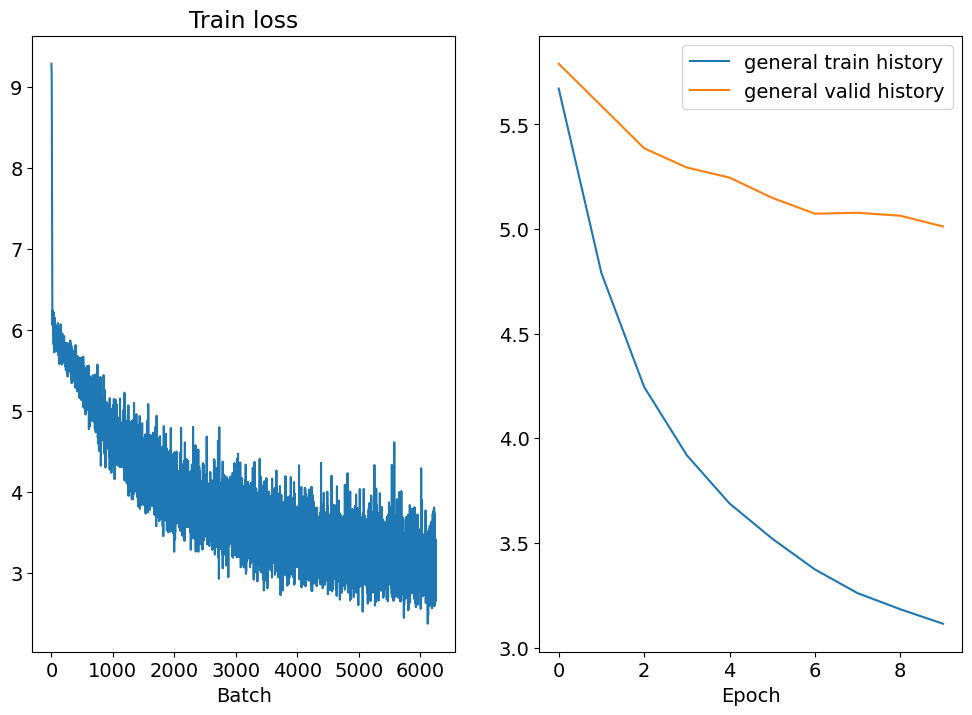

Total time: 22m 25s


In [42]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index = TRG_vocab['<pad>']),
            CLIP=1,
            N_EPOCHS=10,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='baseline.pt')

In [43]:
translation_examples(model, device)

Original: в собственной ванной комнате предоставляются туалетно - косметические принадлежности и фен .
Generated: в собственной ванной комнате предоставляются бесплатные туалетно - косметические принадлежности и фен .

Original: до магазинов и ресторанов 700 метров .
Generated: в 200 метрах от апартаментов работают супермаркет и рестораны .

Original: апартаменты « трускавец » находятся в городе трускавец , в 18 минутах ходьбы от железнодорожного вокзала .
Generated: апартаменты расположены в городе , в в минутах ходьбы от железнодорожного вокзала .

Original: на территории апартаментов работает ресторан can , в котором гостям предложат блюда средиземноморской кухни .
Generated: в ресторане работает ресторан , где подают блюда блюда и интернациональной кухни .

Original: предоставляется бесплатный wi - fi на всей территории и бесплатная частная парковка .
Generated: к услугам гостей бесплатный wi - fi и бесплатная частная парковка .



In [44]:
bleu_score(model)

14.789285414978186

## BPE Tokenization

In [37]:
from tokenizers import CharBPETokenizer

tokenizer = CharBPETokenizer()

tokenizer.train("data.txt", min_frequency=3,  special_tokens=['<unk>', '<pad>', '<sos>', '<eos>'])

def bpe_tokenize(sentance):
    return tokenizer.encode(sentance.lower()).tokens

bpe_tokenized_data = [[bpe_tokenize(x[0]), bpe_tokenize(x[1])] for x in data]

print(f"WordPunctTokenizer: {data[0]}")
print(f"CharBPETokenizer src: {bpe_tokenized_data[0][0]}")
print(f"CharBPETokenizer trg: {bpe_tokenized_data[0][1]}")




WordPunctTokenizer: ['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.', 'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.']
CharBPETokenizer src: ['cor', 'del', 'ia</w>', 'hotel</w>', 'is</w>', 'situated</w>', 'in</w>', 't', 'bil', 'isi</w>', ',</w>', 'a</w>', '3</w>', '-</w>', 'minute</w>', 'walk</w>', 'away</w>', 'from</w>', 's', 'ain', 't</w>', 'tr', 'in', 'ity</w>', 'church</w>', '.</w>']
CharBPETokenizer trg: ['отель</w>', 'cor', 'del', 'ia</w>', 'расположен</w>', 'в</w>', 'т', 'билис', 'и</w>', ',</w>', 'в</w>', '3</w>', 'минутах</w>', 'ходьбы</w>', 'от</w>', 'свя', 'то</w>', '-</w>', 'тро', 'и', 'цкого</w>', 'собора</w>', '.</w>']


Length distribution in BPE tokenized dataset


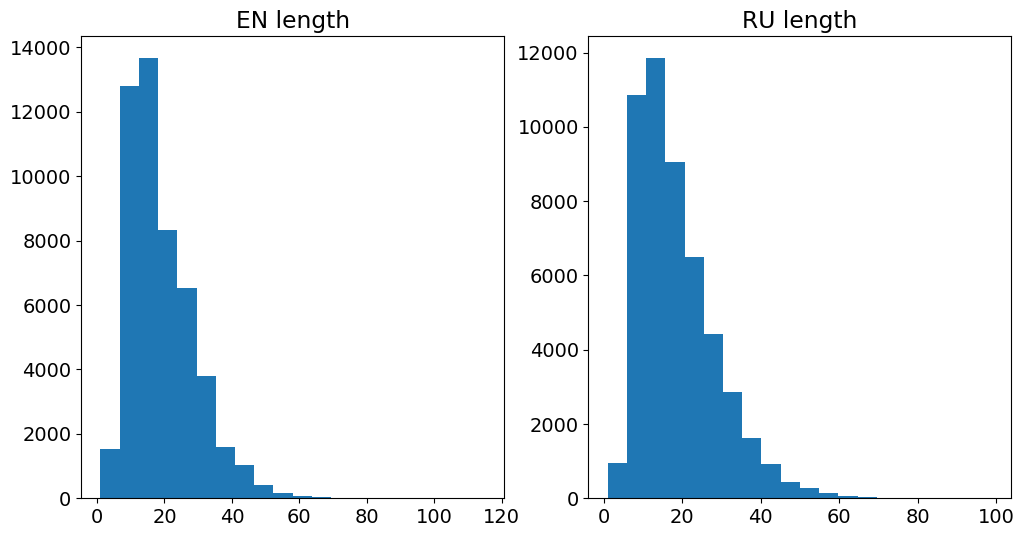

In [38]:
src_length = map(len, [x[0] for x in bpe_tokenized_data])
trg_length = map(len, [x[1] for x in bpe_tokenized_data])

print('Length distribution in BPE tokenized dataset')
plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.title("EN length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("RU length")
plt.hist(list(trg_length), bins=20);

In [42]:
def build_bpe_vocabs(tokenized_data, min_freq):
    src_counter = Counter([x for xs in tokenized_data for x in xs[0]])
    trg_counter = Counter([x for xs in tokenized_data for x in xs[1]])

    SRC_vocab = Vocab(src_counter, min_freq)
    TRG_vocab = Vocab(trg_counter, min_freq)

    for vocab in [SRC_vocab, TRG_vocab]:
        vocab.insert_token('<pad>', index=0)
        if '<unk>' not in vocab:
            vocab.insert_token('<unk>', index=1)
        vocab.set_default_index(vocab['<unk>'])
        vocab.insert_token('<sos>', index=2)
        vocab.insert_token('<eos>', index=3)

    return SRC_vocab, TRG_vocab

In [43]:
SRC_vocab, TRG_vocab = build_bpe_vocabs(bpe_tokenized_data, min_freq=3)


print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(TRG_vocab)}")

Unique tokens in source (en) vocabulary: 7285
Unique tokens in target (ru) vocabulary: 12325


In [13]:
train_data, test_data, val_data = random_split(bpe_tokenized_data, [train_size, test_size, val_size])

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate)

src_batch, trg_batch = next(iter(train_dataloader))
print(src_batch.shape, trg_batch.shape)

torch.Size([50, 64]) torch.Size([44, 64])


## BPE model

In [66]:
INPUT_DIM = len(SRC_vocab)
OUTPUT_DIM = len(TRG_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = my_network.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = my_network.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = my_network.Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,520,420 trainable parameters


Epoch: 01 | Time: 3m 9s
	Train Loss: 6.361 | Train PPL: 578.830
	 Val. Loss: 6.565 |  Val. PPL: 709.649
Epoch: 02 | Time: 3m 10s
	Train Loss: 5.412 | Train PPL: 223.982
	 Val. Loss: 6.232 |  Val. PPL: 508.592
Epoch: 03 | Time: 3m 10s
	Train Loss: 4.905 | Train PPL: 135.001
	 Val. Loss: 6.115 |  Val. PPL: 452.376
Epoch: 04 | Time: 3m 8s
	Train Loss: 4.587 | Train PPL:  98.210
	 Val. Loss: 6.007 |  Val. PPL: 406.118
Epoch: 05 | Time: 3m 9s
	Train Loss: 4.364 | Train PPL:  78.600
	 Val. Loss: 5.767 |  Val. PPL: 319.625
Epoch: 06 | Time: 3m 10s
	Train Loss: 4.210 | Train PPL:  67.334
	 Val. Loss: 5.792 |  Val. PPL: 327.658
Epoch: 07 | Time: 3m 9s
	Train Loss: 4.087 | Train PPL:  59.556
	 Val. Loss: 5.728 |  Val. PPL: 307.294
Epoch: 08 | Time: 3m 9s
	Train Loss: 3.970 | Train PPL:  52.962
	 Val. Loss: 5.781 |  Val. PPL: 324.032
Epoch: 09 | Time: 3m 8s
	Train Loss: 3.880 | Train PPL:  48.420
	 Val. Loss: 5.739 |  Val. PPL: 310.615
Epoch: 10 | Time: 3m 10s
	Train Loss: 3.787 | Train PPL:  44.

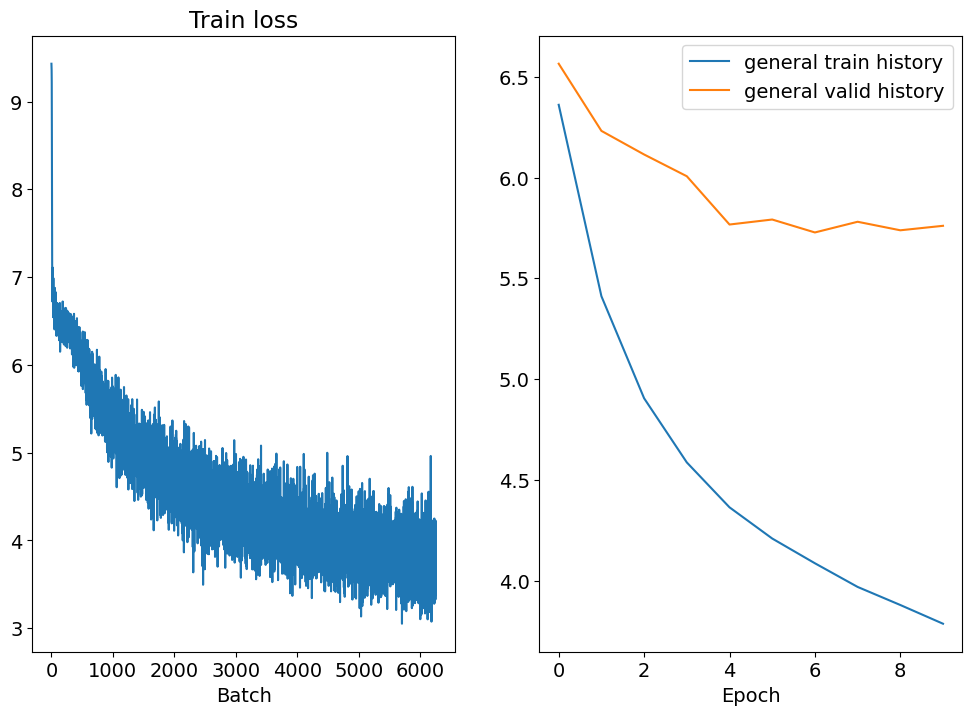

Total time: 31m 36s


In [67]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index = TRG_vocab['<pad>']),
            CLIP=1,
            N_EPOCHS=10,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='bpe.pt')

In [68]:
translation_examples(model, device)

Original: в</w> распоряжении</w> гостей</w> отеля</w> типа</w> «</w> постель</w> и</w> завтрак</w> »</w> wood ley</w> park</w> guest</w> house</w> номера</w> с</w> деревянным</w> полом</w> ,</w> старинной</w> мебелью</w> и</w> кондиционером</w> .</w> в</w> числе</w> удобств</w> письменный</w> стол</w> и</w> собственная</w> ванная</w> комната</w> .</w>
Generated: все</w> номера</w> отеля</w> отеля</w> отеля</w> отеля</w> отель</w> отель</w> отель</w> оформлены</w> в</w> в</w> стиле</w> ,</w> в</w> в</w> числе</w> удобств</w> —</w> ванная</w> комната</w> с</w> душем</w> и</w>

Original: на</w> стойке</w> регистрации</w> гостям</w> предоставляют</w> бесплатную</w> информацию</w> о</w> пешеходных</w> и</w> велосипедных</w> маршру тах</w> .</w>
Generated: в</w> окрестностях</w> можно</w> взять</w> напрокат</w> велосипед</w> ,</w> а</w> также</w> и</w> .</w>

Original: апартаменты</w> b ah ía</w> blan ca</w> с</w> видом</w> на</w> море</w> расположены</w> в</w> городе</w> мар белье</w> ,</w>

In [69]:
bleu_score(model)

11.818880235557017

## Pretrained BPE

In [44]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

def Tokenize(sentances):
    src = tokenizer.tokenize(sentances[0])
    with tokenizer.as_target_tokenizer():
        trg = tokenizer.tokenize(sentances[1])
    return [src, trg]

bpe_tokenized_data = [Tokenize(x) for x in data]

print(f"WordPunctTokenizer: {data[0]}")
print(f"CharBPETokenizer src: {bpe_tokenized_data[0][0]}")
print(f"CharBPETokenizer trg: {bpe_tokenized_data[0][1]}")

/home/semyon/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


WordPunctTokenizer: ['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.', 'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.']
CharBPETokenizer src: ['▁Cor', 'del', 'ia', '▁Hotel', '▁is', '▁situated', '▁in', '▁Tbilisi', ',', '▁a', '▁3', '-', 'minute', '▁walk', '▁away', '▁from', '▁Saint', '▁Trinity', '▁Church', '.']
CharBPETokenizer trg: ['▁От', 'ель', '▁C', 'ord', 'el', 'ia', '▁расположен', '▁в', '▁Тбилиси', ',', '▁в', '▁3', '▁минут', 'ах', '▁ход', 'ь', 'бы', '▁от', '▁Свят', 'о', '-', 'Тр', 'о', 'и', 'цк', 'ого', '▁со', 'бор', 'а', '.']


Length distribution in BPE tokenized dataset


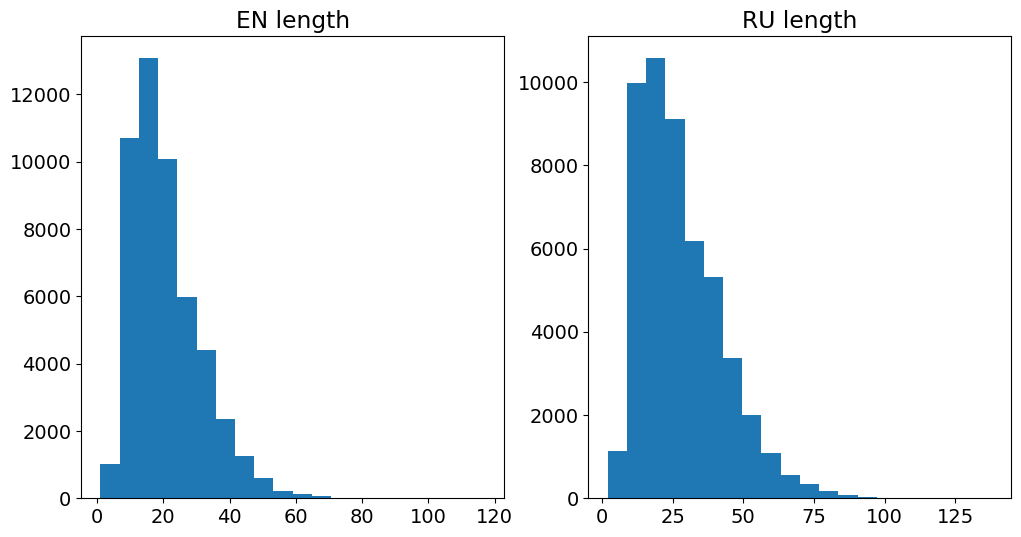

In [45]:
src_length = map(len, [x[0] for x in bpe_tokenized_data])
trg_length = map(len, [x[1] for x in bpe_tokenized_data])

print('Length distribution in BPE tokenized dataset')
plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.title("EN length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("RU length")
plt.hist(list(trg_length), bins=20);

In [49]:
SRC_vocab, TRG_vocab = build_bpe_vocabs(bpe_tokenized_data, min_freq=2)


print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(TRG_vocab)}")

Unique tokens in source (en) vocabulary: 7777
Unique tokens in target (ru) vocabulary: 7257


In [51]:
train_data, test_data, val_data = random_split(bpe_tokenized_data, [train_size, test_size, val_size])

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate)

src_batch, trg_batch = next(iter(train_dataloader))
print(src_batch.shape, trg_batch.shape)

torch.Size([55, 64]) torch.Size([89, 64])


In [53]:
INPUT_DIM = len(SRC_vocab)
OUTPUT_DIM = len(TRG_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = my_network.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = my_network.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = my_network.Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,141,162 trainable parameters


Epoch: 01 | Time: 3m 3s
	Train Loss: 5.049 | Train PPL: 155.861
	 Val. Loss: 6.322 |  Val. PPL: 556.707
Epoch: 02 | Time: 3m 3s
	Train Loss: 4.419 | Train PPL:  83.039
	 Val. Loss: 6.362 |  Val. PPL: 579.503
Epoch: 03 | Time: 3m 3s
	Train Loss: 4.100 | Train PPL:  60.322
	 Val. Loss: 6.369 |  Val. PPL: 583.193
Epoch: 04 | Time: 3m 4s
	Train Loss: 3.902 | Train PPL:  49.515
	 Val. Loss: 6.235 |  Val. PPL: 510.436
Epoch: 05 | Time: 3m 4s
	Train Loss: 3.767 | Train PPL:  43.233
	 Val. Loss: 6.284 |  Val. PPL: 535.861
Epoch: 06 | Time: 3m 3s
	Train Loss: 3.633 | Train PPL:  37.808
	 Val. Loss: 6.221 |  Val. PPL: 503.316
Epoch: 07 | Time: 3m 3s
	Train Loss: 3.559 | Train PPL:  35.115
	 Val. Loss: 6.163 |  Val. PPL: 474.876
Epoch: 08 | Time: 3m 4s
	Train Loss: 3.498 | Train PPL:  33.063
	 Val. Loss: 6.159 |  Val. PPL: 472.926
Epoch: 09 | Time: 3m 3s
	Train Loss: 3.419 | Train PPL:  30.550
	 Val. Loss: 6.117 |  Val. PPL: 453.321
Epoch: 10 | Time: 3m 2s
	Train Loss: 3.353 | Train PPL:  28.588


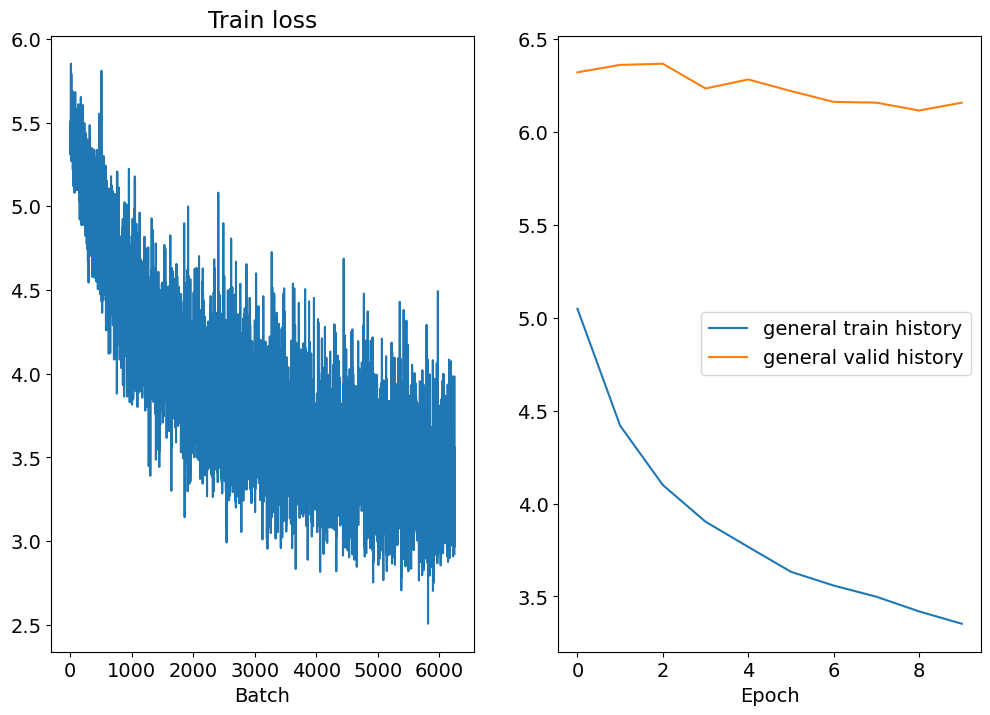

Total time: 30m 37s


In [55]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index = TRG_vocab['<pad>']),
            CLIP=1,
            N_EPOCHS=10,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='bpe_pretrained.pt')

In [56]:
translation_examples(model, device)

Original: ▁Все ▁номера ▁просто ▁оформлен ы ▁и ▁оснащены ▁кондицион е ром .
Generated: ▁Все ▁номера ▁оформлен ы ▁в ▁класс ическом ▁с тил е ▁и ▁оснащены ▁кондицион е ром .

Original: ▁От ель ▁K a mp ung ▁C en ik ▁находится ▁в ▁2 ▁минут ах ▁ход ь бы ▁от ▁с у вен ир ного ▁центра ▁K ri s na . ▁К ▁услугам ▁гостей ▁все ▁современные ▁удобства ▁в ▁традиционных ▁дерев я нных ▁дома х .
Generated: ▁От ель ▁S a a a ▁находится ▁в ▁в ▁минут ах ▁ход ь бы ▁от ▁пляж а ▁и ▁в - ▁и - ▁и - С а . ▁К ▁услугам ▁гостей ▁номера ▁с ▁с а .

Original: ▁Рас стоя ние ▁до ▁аэропорта ▁Сир ил ▁И . ▁К инг ▁составляет ▁ 4,4 ▁к м .
Generated: ▁Рас стоя ние ▁до ▁аэропорта ▁аэропорта пли ▁составляет ▁составляет ▁к м .

Original: ▁В ▁собственной ▁в а нной ▁комнате ▁номеров ▁установлен ▁душ ▁и ▁предоставляются ▁бесплатны е ▁туалет но - кос мет ические ▁принадлежности .
Generated: ▁В ▁собственной ▁в а нной ▁комнате ▁предоставляются ▁бесплатны е ▁туалет но - кос мет ические ▁принадлежности .

Original: ▁Рас стоя ние ▁до ▁железно

In [57]:
bleu_score(model)

18.62284812387132

## Attention

In [9]:
with open("data.txt") as f:
    data = [s.rstrip().split("\t") for s in f]

size = len(data)
train_size = int(0.8 * size)
test_size = int(0.15 * size)
val_size = int(0.05 * size)
train_data, test_data, val_data = random_split(data, [train_size, test_size, val_size])

train_data, test_data, val_data = random_split(data, [train_size, test_size, val_size])

src_tokenizer = Tokenizer(WordPiece(unk_token='<unk>'))
trg_tokenizer = Tokenizer(WordPiece(unk_token='<unk>'))

src_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])
trg_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])

src_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])
trg_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])

src_tokenizer.decoder = decoders.WordPiece()
trg_tokenizer.decoder = decoders.WordPiece()

src_trainer = WordPieceTrainer(special_tokens=['<unk>', '<sos>', '<pad>', '<eos>'], vocab_size=10000)
trg_trainer = WordPieceTrainer(special_tokens=['<unk>', '<sos>', '<pad>', '<eos>'], vocab_size=10000)

src_tokenizer.train_from_iterator([x[0] for x in train_data], trainer=src_trainer)
trg_tokenizer.train_from_iterator([x[1] for x in train_data], trainer=trg_trainer)


print(f"Source (en) vocabulary size: {src_tokenizer.get_vocab_size()}")
print(f"Target (ru) vocabulary size: {trg_tokenizer.get_vocab_size()}")







Source (en) vocabulary size: 10000
Target (ru) vocabulary size: 10000


In [10]:
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src, trg in batch:
        src_processed = [src_tokenizer.token_to_id('<sos>')] + src_tokenizer.encode(src).ids + [src_tokenizer.token_to_id('<eos>')]
        src_batch.append(torch.tensor(src_processed))

        trg_processed = [trg_tokenizer.token_to_id('<sos>')] + trg_tokenizer.encode(trg).ids + [trg_tokenizer.token_to_id('<eos>')]
        trg_batch.append(torch.tensor(trg_processed))

    src_padded = pad_sequence(src_batch, padding_value=src_tokenizer.token_to_id('<pad>'))
    trg_padded = pad_sequence(trg_batch, padding_value=trg_tokenizer.token_to_id('<pad>'))
    return src_padded, trg_padded

batch_size = 100
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
print(src_batch.shape, trg_batch.shape)

torch.Size([43, 100]) torch.Size([59, 100])


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden


class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention = torchnlp.nn.Attention(hid_dim)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, encoder_outputs, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.dropout(self.embedding(input))

        context, _ = self.attention(hidden[-1].unsqueeze(1), encoder_outputs.swapaxes(0, 1))
        context = context.swapaxes(0, 1)

        rnn_input = torch.cat((embedded, context), dim=-1)
        output, hidden = self.rnn(rnn_input, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden
      


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_outputs, hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, encoder_outputs, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [12]:
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = my_network.Encoder(src_tokenizer.get_vocab_size(), ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = my_network.Decoder(trg_tokenizer.get_vocab_size(), DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = my_network.Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,973,200 trainable parameters


Epoch: 01 | Time: 2m 59s
	Train Loss: 5.339 | Train PPL: 208.262
	 Val. Loss: 6.146 |  Val. PPL: 467.075
Epoch: 02 | Time: 2m 58s
	Train Loss: 4.881 | Train PPL: 131.769
	 Val. Loss: 6.088 |  Val. PPL: 440.601
Epoch: 03 | Time: 2m 57s
	Train Loss: 4.595 | Train PPL:  98.948
	 Val. Loss: 6.005 |  Val. PPL: 405.426
Epoch: 04 | Time: 2m 59s
	Train Loss: 4.361 | Train PPL:  78.307
	 Val. Loss: 5.935 |  Val. PPL: 377.878
Epoch: 05 | Time: 2m 58s
	Train Loss: 4.230 | Train PPL:  68.688
	 Val. Loss: 5.951 |  Val. PPL: 384.246
Epoch: 06 | Time: 2m 59s
	Train Loss: 4.107 | Train PPL:  60.743
	 Val. Loss: 5.875 |  Val. PPL: 355.967
Epoch: 07 | Time: 2m 58s
	Train Loss: 4.015 | Train PPL:  55.402
	 Val. Loss: 5.860 |  Val. PPL: 350.734
Epoch: 08 | Time: 2m 57s
	Train Loss: 3.927 | Train PPL:  50.756
	 Val. Loss: 5.754 |  Val. PPL: 315.314
Epoch: 09 | Time: 3m 0s
	Train Loss: 3.850 | Train PPL:  46.992
	 Val. Loss: 5.833 |  Val. PPL: 341.304
Epoch: 10 | Time: 2m 56s
	Train Loss: 3.782 | Train PPL:

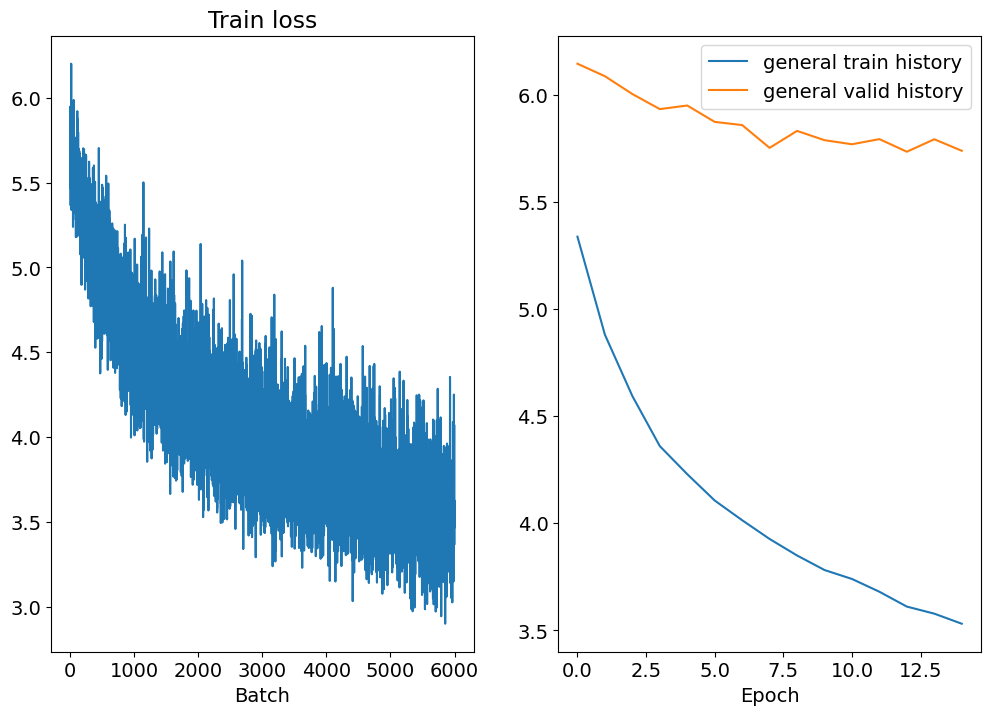

Total time: 44m 56s


In [14]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index=trg_tokenizer.token_to_id('<pad>')),
            CLIP=1,
            N_EPOCHS=15,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='attention.pt')

## Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, trg_vocab_size, dim_feedforward = 512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, trg_vocab_size)
        self.src_token_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.trg_token_emb = TokenEmbedding(trg_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask=None, trg_mask=None, src_padding_mask=None, trg_padding_mask=None, memory_key_padding_mask=None):
        src_emb = self.positional_encoding(self.src_token_emb(src))
        trg_emb = self.positional_encoding(self.trg_token_emb(trg))
        outs = self.transformer(src_emb, trg_emb, src_mask, trg_mask, None, src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask=None):
        return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

    def decode(self, trg, memory, trg_mask=None):
        return self.transformer.decoder(self.positional_encoding(self.trg_token_emb(trg)), memory, trg_mask)

    def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


    def create_mask(src, trg, device):
        src_seq_len = src.shape[0]
        trg_seq_len = trg.shape[0]

        trg_mask = generate_square_subsequent_mask(trg_seq_len, device)
        src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

        src_padding_mask = (src == src_pad_token_id).transpose(0, 1)
        trg_padding_mask = (trg == trg_pad_token_id).transpose(0, 1)
        return src_mask, trg_mask, src_padding_mask, trg_padding_mask